In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import pandas_datareader.data as reader
from fredapi import Fred
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
def human_format_dollar_or_num(dollar=False, decimals=0):
    """ Returns a function that can be used to format matplot axes large numbers human friendly. 

    Arguments:
    dollar -- logical. If True, will add $ in front of the numbers.
    """

    base_fmt = '%.{}f%s'.format(decimals)
    if dollar:
        base_fmt = '$' + base_fmt

    def human_format(num, pos): # pos is necessary as it'll be used by matplotlib
        magnitude = 0
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        return base_fmt % (num, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])
    return human_format

## Get Data from [FRED](https://fred.stlouisfed.org/)

- The Size (Assets) of the Fed’s Balance Sheet
- NY Fed Total Amount of Accepted Reverse Repo Bids  
- US Treasury General Account Balance Held at NY Fed 

In [3]:
fred = Fred(api_key = os.environ.get('FRED_API_KEY'))

In [4]:
# Fed Balance Sheet: raw values are in millions of dollars => dollars
assets = fred.get_series('WALCL') * 1e6
# liabilities = fred.get_series('WLTLECL') * 1e6
# capital = fred.get_series('WCTCL') * 1e6

# Reverse Repo (RRP) Balances held at the NY Fed: raw values are in billions of dollars => dollars
rrp = fred.get_series('RRPONTTLD') * 1e9

# Treasury's General Account Balance Held at NY Fed: raw values are in billions of dollars => dollars
tga = fred.get_series('WTREGEN') * 1e9

## Construct the Hayes USD Liquidity Conditions Index

- Hayes USD Liquidity Conditions Index = The Fed’s Balance Sheet — NY Fed Total Amount of Accepted Reverse Repo Bids — US Treasury General Account Balance Held at NY Fed.

See this [article](https://cryptohayes.medium.com/teach-me-daddy-33e7a66dfe76) by Arthur Hayes.

In [5]:
# input
start_date = '2021-12-01'
end_date = dt.datetime.now().strftime('%Y-%m-%d')

In [6]:
x = (assets - tga).loc[start_date:end_date].dropna()
x.head()

2021-12-01   8,497,751,000,000.0000
2021-12-08   8,549,407,000,000.0000
2021-12-15   8,651,868,000,000.0000
2021-12-22   8,705,541,000,000.0000
2021-12-29   8,545,611,000,000.0000
dtype: float64

In [7]:
x = x.reindex(pd.date_range(x.index.min(), x.index.max())).ffill()
x.head(8)

2021-12-01   8,497,751,000,000.0000
2021-12-02   8,497,751,000,000.0000
2021-12-03   8,497,751,000,000.0000
2021-12-04   8,497,751,000,000.0000
2021-12-05   8,497,751,000,000.0000
2021-12-06   8,497,751,000,000.0000
2021-12-07   8,497,751,000,000.0000
2021-12-08   8,549,407,000,000.0000
Freq: D, dtype: float64

In [8]:
HUSDLCI = (x - rrp).dropna() # dollars
HUSDLCI.name = 'HUSDLCI'
HUSDLCI.tail()  

2022-08-11   6,122,626,000,000.0000
2022-08-12   6,108,680,000,000.0000
2022-08-15   6,146,016,000,000.0000
2022-08-16   6,156,541,000,000.0000
2022-08-17   6,104,810,000,000.0000
Name: HUSDLCI, dtype: float64

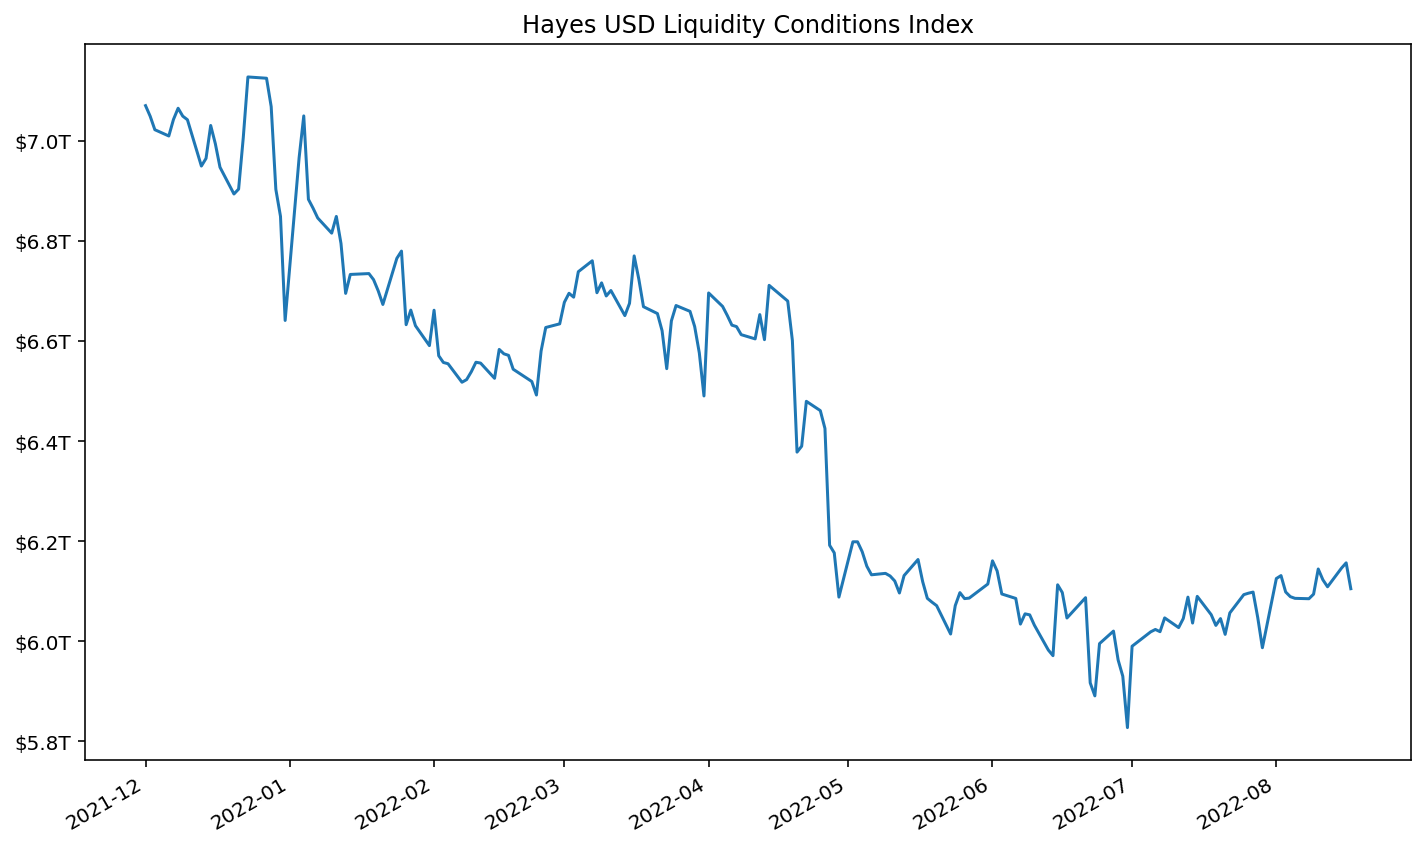

In [9]:
ax = HUSDLCI.plot()
ax.set(title="Hayes USD Liquidity Conditions Index", ylabel='')
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=1))
ax.yaxis.set_major_formatter(formatter)
plt.tight_layout()

## Overlay with BTC Price

In [10]:
btc = reader.get_data_yahoo('BTC-USD', start_date, end_date)['Close']
btc.name = 'BTCUSD'
btc

Date
2021-11-30   57,005.4258
2021-12-01   57,229.8281
2021-12-02   56,477.8164
2021-12-03   53,598.2461
2021-12-04   49,200.7031
                 ...    
2022-08-21   21,534.1211
2022-08-22   21,398.9082
2022-08-23   21,528.0879
2022-08-24   21,395.0195
2022-08-25   21,536.5566
Name: BTCUSD, Length: 269, dtype: float64

In [11]:
dat = pd.concat([HUSDLCI, btc], axis=1).dropna()
dat.tail()

,HUSDLCI,BTCUSD
2022-08-11,"6,122,626,000,000.0000","23,957.5293"
2022-08-12,"6,108,680,000,000.0000","24,402.8184"
2022-08-15,"6,146,016,000,000.0000","24,136.9727"
2022-08-16,"6,156,541,000,000.0000","23,883.2910"
2022-08-17,"6,104,810,000,000.0000","23,335.9980"


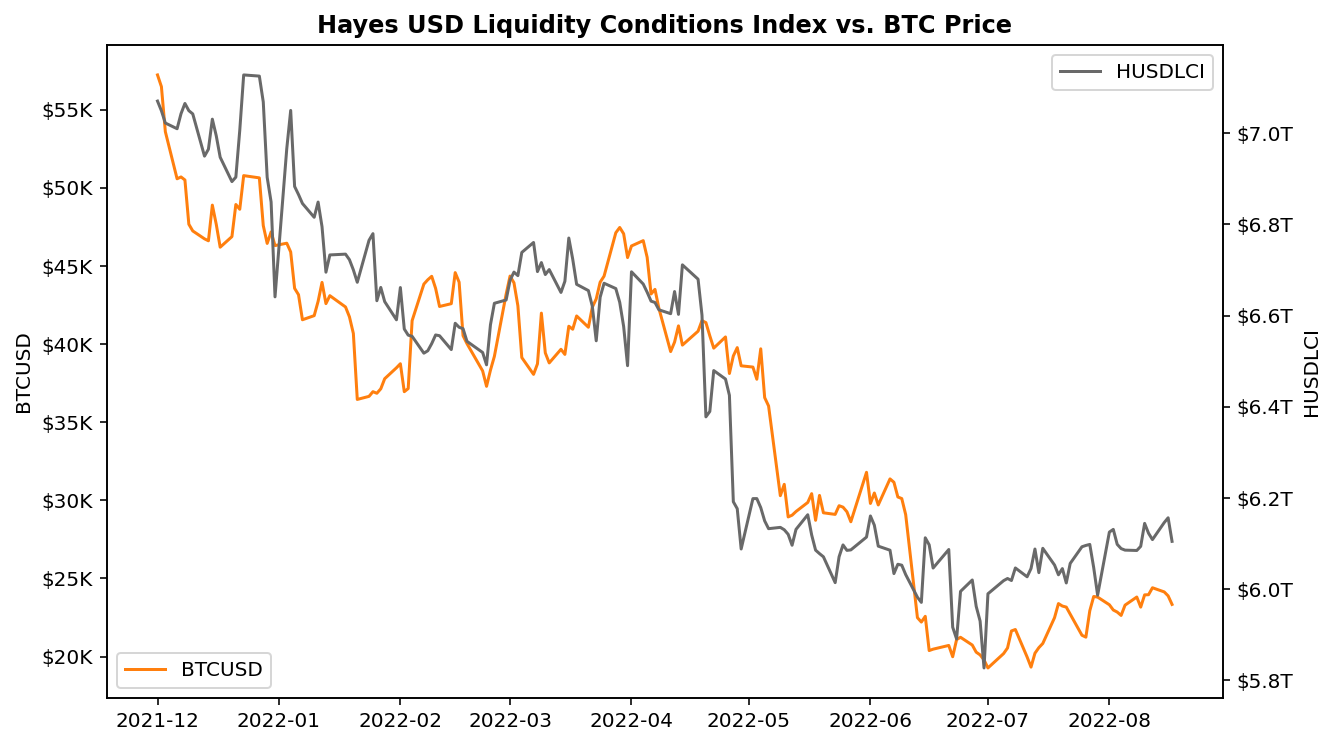

In [15]:
# Plotting dataset_2
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dat.index, dat.BTCUSD, '-', color='tab:orange', label='BTCUSD')
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)

# Creating Twin axes for dataset_1
ax2 = ax.twinx()
ax2.plot(dat.index, dat.HUSDLCI, '-', color='dimgray', label='HUSDLCI')
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=1))
ax2.yaxis.set_major_formatter(formatter) 

plt.title('Hayes USD Liquidity Conditions Index vs. BTC Price', fontweight="bold")
ax.legend(loc='lower left')
ax2.legend(loc='upper right')
 
ax.set_ylabel('BTCUSD')
ax2.set_ylabel('HUSDLCI');